In [4]:
def get_activations(modele, text):

    inpt, attention_out, ff_out, output = modele.get_text_activations(text)
    inpt, attention_out, ff_out, output = inpt.cpu(), attention_out.cpu(), ff_out.cpu(), output.cpu()
    attn0 = attention_out[0]
    attn1 = attention_out[int(len(attention_out)/2)]
    attn2 = attention_out[-1]
    ff0 = ff_out[0]
    ff1 = ff_out[int(len(ff_out)/2)]
    ff2 = ff_out[-1]

    return torch.stack((inpt, attn0, ff0, attn1, ff1, attn2, ff2, output))

def get_residual(modele, text):

    residual_stream = modele.get_residual_stream(text)
    return torch.stack((residual_stream[0], residual_stream[1], residual_stream[2], residual_stream[31], residual_stream[32], residual_stream[63], residual_stream[64]))


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import json
import copy
from taker import Model
import seaborn as sns
import matplotlib.pyplot as plt


torch.pi = torch.acos(torch.zeros(1)).item() * 2 #3.1415927410125732

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate activations if there are none
m = Model("mistralai/Mistral-7B-v0.1", dtype="nf4")
m.do_activations["mlp_pre_out"] = False
m.do_activations["attn_pre_out"] = False


# copied from transformers.models.llama.modeling_llama.LlamaSdpaAttention with Llama->Mistral
# TODO @Arthur no longer copied from LLama after static cache

import math

from transformers.models.mistral.modeling_mistral import MistralSdpaAttention

class Lora(nn.Module):
    def __init__(self, input_dim, output_dim, rank=4, dtype=torch.float16, use_bias=False):
        super(Lora, self).__init__()
        # Low-rank matrices A and B
        self.output_dim = output_dim
        self.A = nn.Parameter(torch.Tensor(rank, input_dim ).to(dtype=dtype))
        self.B = nn.Parameter(torch.Tensor(output_dim, rank).to(dtype=dtype))
        self._reset_parameters()

    def _reset_parameters(self):
        # Initialize A with Kaiming uniform and B with zeros
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)

    def _A(self, x):
        return F.linear(input=x, weight=self.A)

    def _B(self, x):
        return F.linear(input=x, weight=self.B)

    def forward(self, x):
        # Compute only the LoRA adaptation without the standard linear component
        return self._B(self._A(x))

class LoraLinear(nn.Module):
    def __init__(self, linear, lora, use_bias=False):
        super(LoraLinear, self).__init__()
        # Low-rank matrices A and B
        self.linear = linear
        self.lora = lora
        self.bias = None
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros([self.lora.output_dim]))

    def forward(self, x):
        y = self.linear(x) + self.lora(x)
        if self.bias is not None:
            return y + self.bias
        return y

class MistralSdpaLoraAttention(MistralSdpaAttention):
    def __init__(self, orig_attn, rank=4, dtype=torch.float16, use_bias=False):
        super(MistralSdpaLoraAttention, self).__init__(orig_attn.config)
        self.hidden_size = orig_attn.hidden_size
        self.num_heads   = orig_attn.num_heads
        self.head_dim    = orig_attn.head_dim
        self.rope_theta  = orig_attn.rope_theta
        self.is_causal   = True
        self.num_key_value_heads     = orig_attn.num_key_value_heads
        self.num_key_value_groups    = orig_attn.num_key_value_groups
        self.max_position_embeddings = orig_attn.max_position_embeddings
        self.attention_dropout       = orig_attn.attention_dropout

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        # Assuming orig_attn has the following attributes already initialized
        d_model = self.hidden_size
        d_kv = self.num_key_value_heads * self.head_dim
        n_kv = self.num_key_value_groups

        # load up modified attentions
        # self.q_proj_orig = orig_attn.q_proj  # Projects input to query space, size: [hidden_size, num_heads * head_dim]
        self.q_proj = LoraLinear(
            orig_attn.q_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.k_proj_orig = orig_attn.k_proj  # Projects input to key space, size: [hidden_size, num_key_value_heads * head_dim]
        self.k_proj = LoraLinear(
            orig_attn.k_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.v_proj_orig = orig_attn.v_proj  # Projects input to value space, size: [hidden_size, num_key_value_heads * head_dim]
        self.v_proj = LoraLinear(
            orig_attn.v_proj,
            Lora(d_model, d_kv, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )
        # self.o_proj_orig = orig_attn.o_proj  # Projects concatenated outputs back to hidden_size, size: [num_heads * head_dim, hidden_size]
        self.o_proj = LoraLinear(
            orig_attn.o_proj,
            Lora(d_model, d_model, rank=rank, dtype=dtype),
            use_bias=use_bias,
        )

        self.lora_list = [
            self.q_proj.lora,
            self.k_proj.lora,
            self.v_proj.lora,
            self.o_proj.lora,
        ]
        self.bias_list = []
        if use_bias:
            self.bias_list += [
                self.q_proj.bias,
                self.k_proj.bias,
                self.v_proj.bias,
                self.o_proj.bias,
            ]

        self.rotary_emb = orig_attn.rotary_emb

    def lora_params(self):
        for component in self.lora_list:
            for param in component.parameters():
                yield param
        for bias in self.bias_list:
            yield bias

class TunedConstant(nn.Module):
    def __init__(self, value):
        super(TunedConstant, self).__init__()
        self.value = nn.Parameter(value)

    def forward(self):
        return self.value

def new_train(num_epochs=50, save=False):
    full_dataset = TensorDataset(act_in.to("cuda"), act_mean_out.to("cuda"))
    train_dataset, val_dataset = random_split(full_dataset, [0.8, 0.2])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
    model = attn_lora.float()

    if save:
        untrained = copy.deepcopy(attn_lora)

    params = [
        *attn_lora.lora_params(),
        *attn_mean_in.parameters()
    ]

    optimizer = optim.Adam(params)
    #mse = nn.MSELoss()

    def criterion(output, target):
        #[batch, 4096], [batch, 4096])
        #return mse(output, target)
        _cos = torch.sum( output * target , dim=1)
        _cos = torch.clamp(_cos, max=1)
        _angle = torch.acos( _cos )
        return _angle.mean() * 180 / torch.pi

    def get_prediction(outputs):
        _out = outputs.mean(dim=-2)
        #_out = outputs[..., -10:, :].mean(dim=-2)
        _out_normed = _out / _out.norm(dim=-1, keepdim=True)
        return _out_normed

    def calculate_loss(outputs, targets):
        #[batch, 100, 4096], [batch, 1, 4096])
        _tgt = targets.mean(dim=-2)
        _tgt_normed = _tgt / _tgt.norm(dim=-1, keepdim=True)
        _out_normed = get_prediction(outputs)
        loss = criterion(_out_normed, _tgt_normed)
        return loss

    def __test():
        model.eval()
        attn_mean_in.eval()
        with torch.no_grad():
            _in, _out = next(iter(val_dataloader))
            inputs, targets = _in.float(), _out.float()
            biais = attn_mean_in().expand(_in.shape[0], 1, -1)
            inputs = inputs+biais
            outputs = model(inputs)[0]
            val_loss = calculate_loss(outputs, targets).item()
        return val_loss

    val_loss = __test()
    print(f'Initial Validation Loss: {val_loss:.8f}')

    
    for epoch in range(num_epochs):
        model.train()
        attn_mean_in.train()
        epoch_loss = 0.0
        for _in, _out in train_dataloader:
            optimizer.zero_grad()
            inputs, targets = _in.float().detach().requires_grad_(), _out.float().detach().requires_grad_()            
            biais = attn_mean_in().expand(inputs.shape[0], 1, -1)
            inputs = inputs + biais
            outputs = model(inputs)[0]
            loss = calculate_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        val_loss = __test()
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.8f}, Validation Loss: {val_loss:.8f})')

    if(save):
        for [modele, file] in [[model, 'trained.pth'], [untrained, 'untrained.pth']]:
            modele.eval()
            attn_mean_in.eval()
            predictions = []
            with torch.no_grad():
                for inputs, _ in full_dataset:
                    biais = attn_mean_in().expand(inputs.shape[0], -1)
                    inputs = inputs + biais
                    inputs = inputs.to('cuda').float().unsqueeze(0)
                    outputs = modele(inputs)[0]
                    predictions.append(get_prediction(outputs.cpu()))

            all_predictions = torch.stack(predictions, dim=0)

            torch.save(all_predictions, file)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


- Loaded mistralai/Mistral-7B-v0.1
 - Registered 32 Attention Layers


In [2]:
loaded_texts  = torch.load(f'generated_texts-1.pth')
prompts = [i[0] for i in loaded_texts]
completions = [i[1] for i in loaded_texts]
full_texts = [i[0] + i[1] for i in loaded_texts]

inpt = []
attn2 = []
with torch.no_grad():
    for text in tqdm(full_texts):
        act = get_activations(m, text).to('cpu')
        inpt.append(act[0][:100])
        attn2.append(act[5][100:120])

act_in = torch.stack(inpt)
act_mean_out = torch.stack(attn2)

100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


In [3]:
attn = m.layers[15]["attn"].to("cuda")
attn_lora = MistralSdpaLoraAttention(attn, rank=4, use_bias=True).to("cuda")

attn_mean_in = TunedConstant(torch.randn([1, attn.hidden_size])).to("cuda", dtype=torch.float32)

#act_in = torch.load('x_inpt.pt')
#act_mean_out = torch.load('y_attn2.pt')

new_train(num_epochs=50, save=True)

Instantiating MistralSdpaLoraAttention without passing a `layer_idx` is not recommended and will lead to errors during the forward call if caching is used. Please make sure to provide a `layer_idx` when creating this class.


Initial Validation Loss: 95.56131744
Epoch [1/50], Training Loss: 393.03795242, Validation Loss: 47.63740540)
Epoch [2/50], Training Loss: 214.92862701, Validation Loss: 39.16432953)
Epoch [3/50], Training Loss: 186.15438461, Validation Loss: 34.98605347)
Epoch [4/50], Training Loss: 167.76750183, Validation Loss: 31.76173401)
Epoch [5/50], Training Loss: 152.01195908, Validation Loss: 28.25820732)
Epoch [6/50], Training Loss: 134.60340691, Validation Loss: 24.62416077)
Epoch [7/50], Training Loss: 121.26883125, Validation Loss: 22.58662033)
Epoch [8/50], Training Loss: 115.08407211, Validation Loss: 22.50144005)
Epoch [9/50], Training Loss: 112.61206627, Validation Loss: 22.40260124)
Epoch [10/50], Training Loss: 111.64246750, Validation Loss: 21.87236786)
Epoch [11/50], Training Loss: 110.96493912, Validation Loss: 21.87120056)
Epoch [12/50], Training Loss: 110.32126427, Validation Loss: 21.79253578)
Epoch [13/50], Training Loss: 109.89954376, Validation Loss: 21.89295959)
Epoch [14/

/tmp/ipykernel_84505/996628542.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  rand_dots[i][j] = o_i.T @ p_j


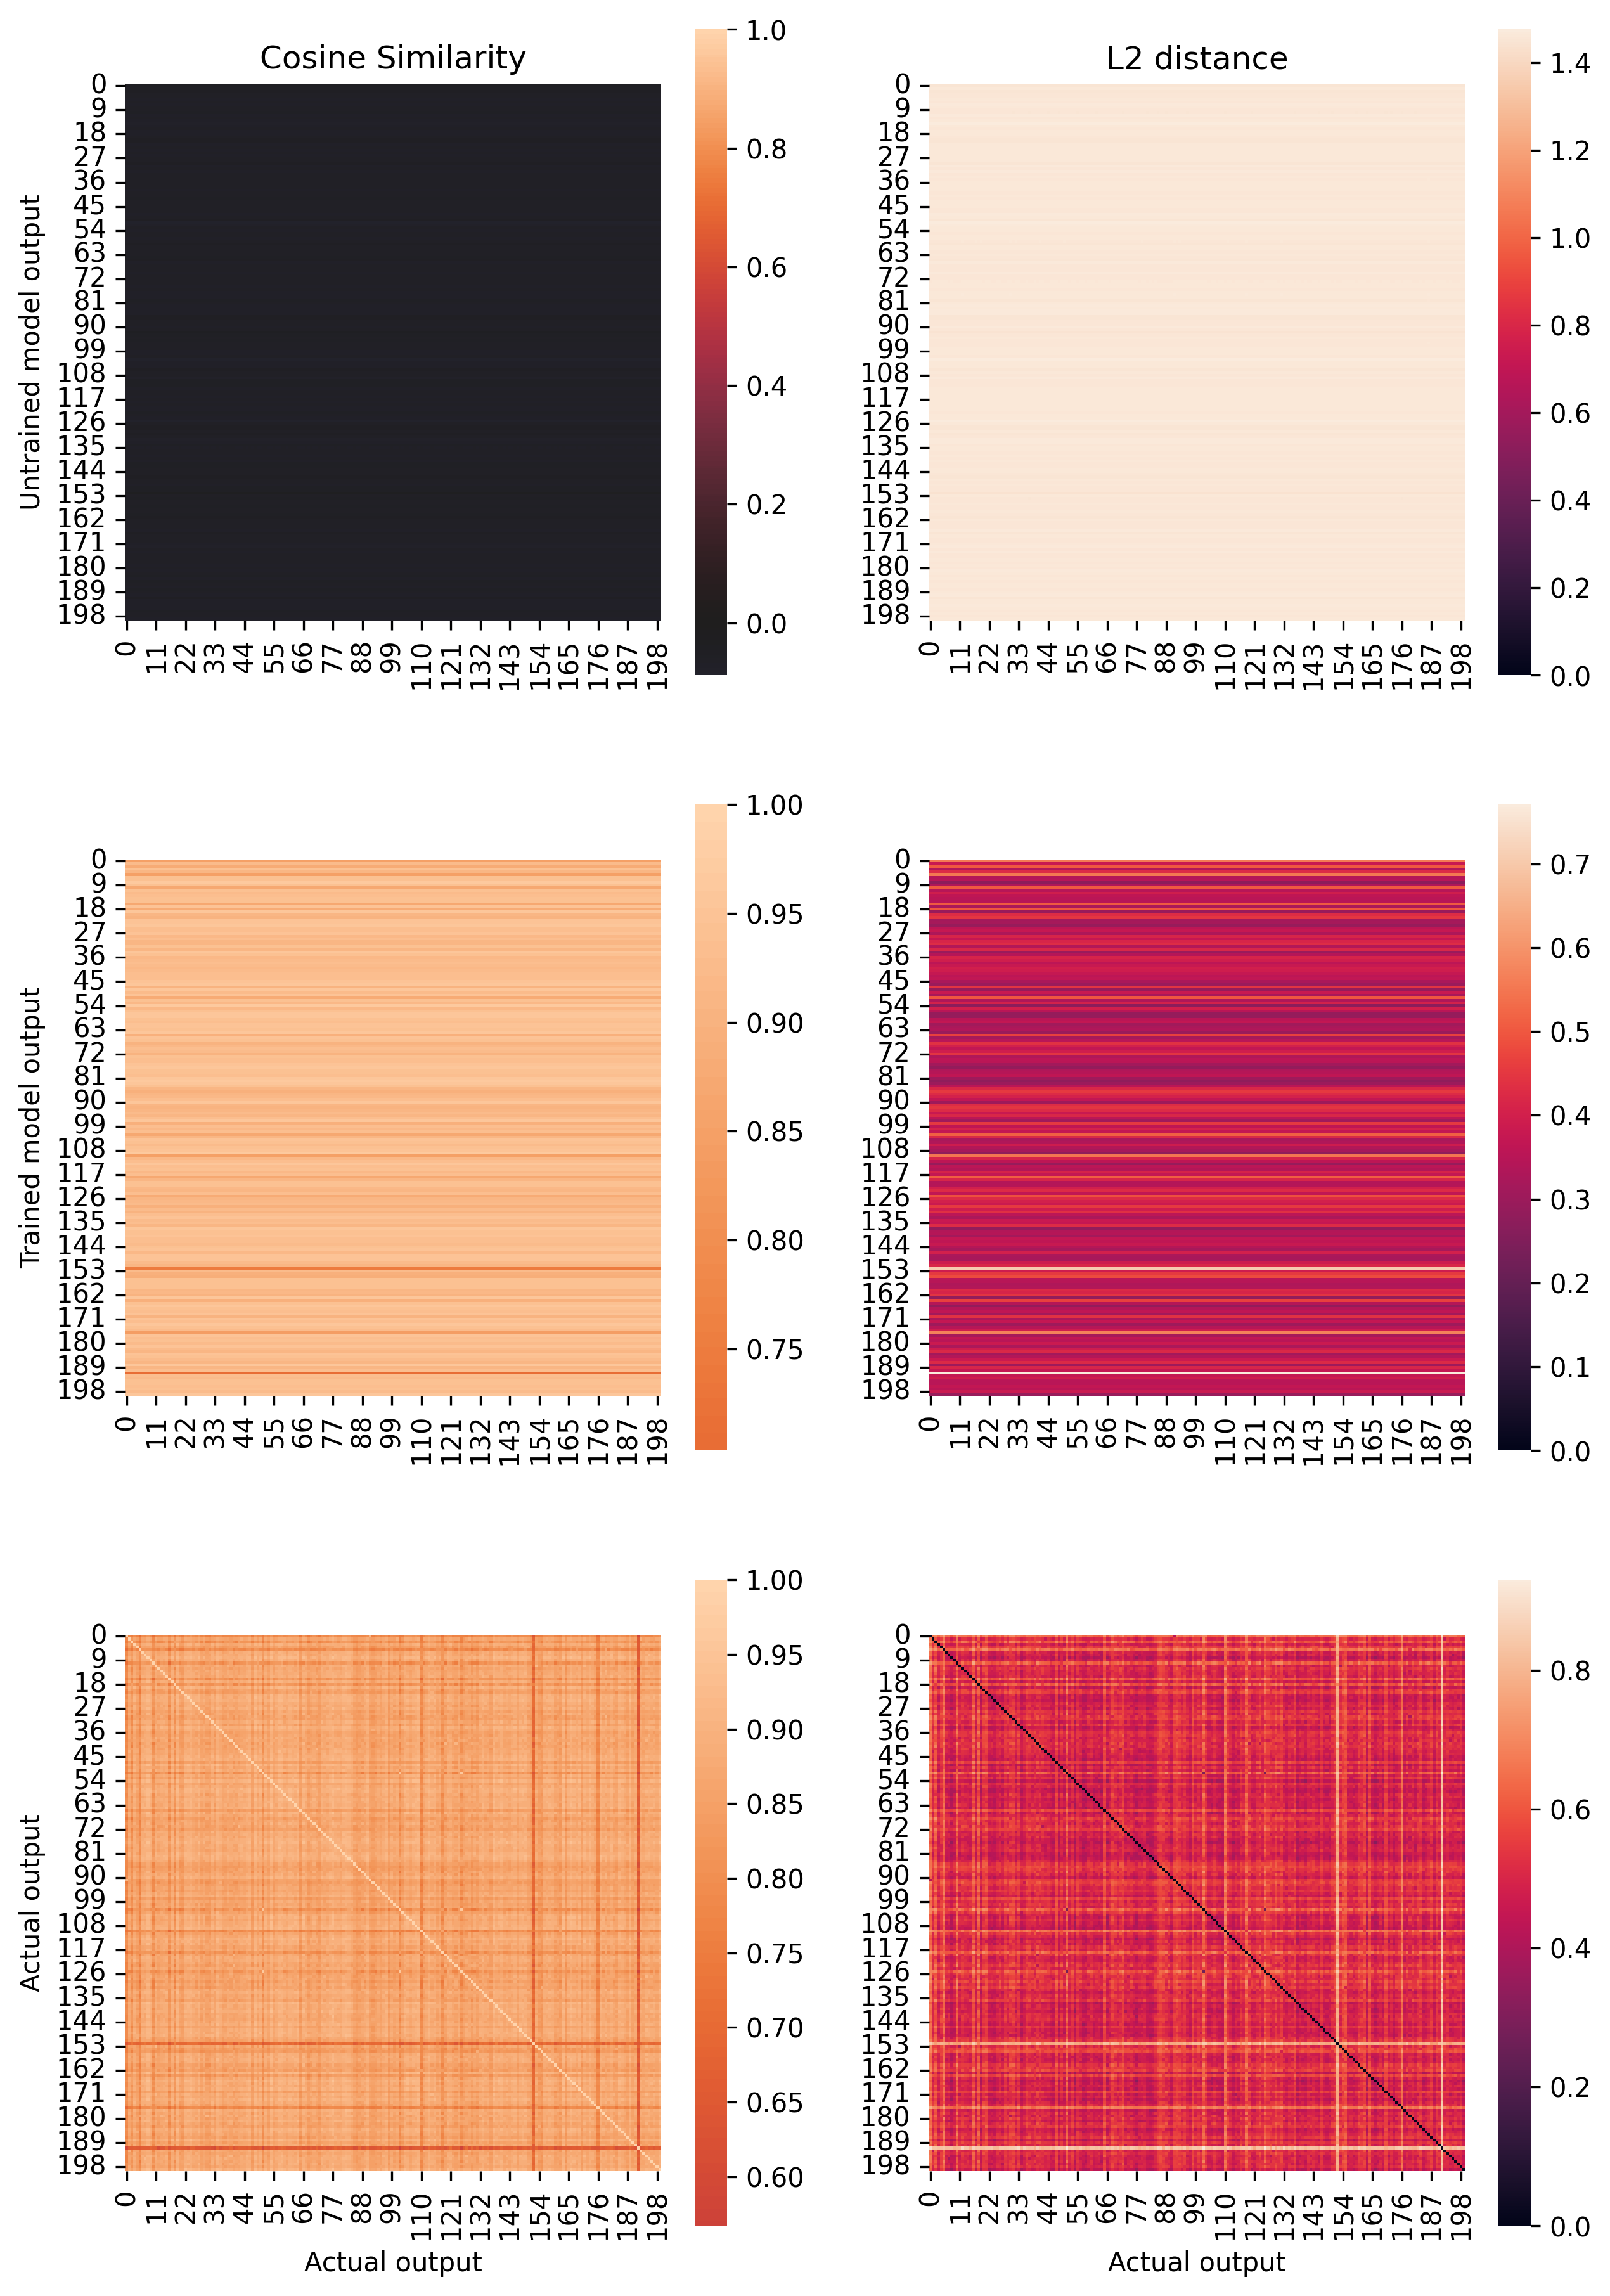

In [5]:
res = torch.load('trained.pth').float()[:200]
res_untrained = torch.load('untrained.pth').float()[:200]

out = act_mean_out.mean(dim=-2)
out_normed = out / out.norm(dim=-1, keepdim=True)

full_dataset = TensorDataset(act_in.cpu().float()[:200], out_normed.cpu().float()[:200])
#full_dataset = TensorDataset(act_in.cpu().float(), out_normed.cpu().float())

n_items = len(full_dataset)
dots = torch.zeros(n_items, n_items)
dist = torch.zeros(n_items, n_items)

#Pre-trained
rand_dist, rand_dots = torch.zeros_like(dist), torch.zeros_like(dots)
for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
    for j, [prediction] in enumerate(res_untrained):
        o_i = (output) #-o_mean)
        p_j = (prediction) #-p_mean)
        o_i /= o_i.norm()
        p_j /= p_j.norm()
        rand_dist[i][j] = ((o_i - p_j)**2).sum().sqrt()
        rand_dots[i][j] = o_i.T @ p_j

#Fine-Tune
for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
    for j, [prediction] in enumerate(res):
        o_i = (output) #-o_mean)
        p_j = (prediction) #-p_mean)
        o_i /= o_i.norm()
        p_j /= p_j.norm()
        dist[i][j] = ((o_i - p_j)**2).sum().sqrt()
        dots[i][j] = o_i.T @ p_j

#Actual vector
expected_dots = torch.zeros_like(dots)
expected_dist = torch.zeros_like(dist)
for i, (inputs, output) in enumerate(full_dataset):  # Assuming your dataset returns inputs and targets
    for j, (_inputs, _output) in enumerate(full_dataset):
        o_i = (output) #-o_mean)
        p_j = (_output) #-p_mean)
        o_i /= o_i.norm()
        p_j /= p_j.norm()
        expected_dist[i][j] = ((o_i - p_j)**2).sum().sqrt()
        expected_dots[i][j] = o_i.T @ p_j        


fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
ax1.set_title("Cosine Similarity")
sns.heatmap(ax=ax1, data=rand_dots, square=True,  center=0.0, vmax=1.0);ax1.set_ylabel("Untrained model output")
sns.heatmap(ax=ax3, data=dots, square=True,  center=0.0, vmax=1.0);ax3.set_ylabel("Trained model output")
sns.heatmap(ax=ax5, data=expected_dots, square=True,  center=0.0, vmax=1.0);ax5.set_ylabel("Actual output")

ax2.set_title("L2 distance")
sns.heatmap(ax=ax2, data=rand_dist, square=True, vmin=0.0)
sns.heatmap(ax=ax4, data=dist, square=True, vmin=0.0)
sns.heatmap(ax=ax6, data=expected_dist, square=True, vmin=0.0)

ax5.set_xlabel("Actual output")
ax6.set_xlabel("Actual output")
plt.show()